**Access Across America (AAA)** from [**Accessibility Observatory**](https://ao.umn.edu/) at the University of Minnesota

* **[Available datasets](https://ao.umn.edu/data/datasets)**
* **[Methodology report for transit access](https://ao.umn.edu/research/america/transit/2019/documents/AccessAcrossAmerica-Transit2019-Methodology.pdf)**
* **[Transit data documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**

# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


In [2]:
from mobilkit.umni import *

In [3]:
import fiona
import yaml

In [4]:
# spatial scales of the maps
SCALES = ('BG', 'COUNTY', 'TRACT')
# travel modes considered
MODES = ('BIKE', 'DRIVE', 'TRANSIT', 'WALK')
# travel time thresholds (in minutes)
TT_THRESHOLDS = (15, 30, 45, 60)

# Prepare data

## Download

**[DRIVE (2018)](https://conservancy.umn.edu/handle/11299/211408)**

Data not available for Indiana 😭

**[TRANSIT (2019)](https://conservancy.umn.edu/handle/11299/218072)**

**[BIKE (2019)](https://conservancy.umn.edu/handle/11299/218194)**

**[WALK (2014)](https://conservancy.umn.edu/handle/11299/173991)**

Only available for Indianapolis region

## Extract layers

In [7]:
def get_aaa_layers(mode, year=2017):
    mode = mode.lower()
    assert mode in ['bike', 'transit']
    fpath = Path(f'../data/aaa/{mode}/indiana.gpkg')
    year = str(year % 2000)
    for layer in tqdm(fiona.listlayers(fpath)):
        if not layer.startswith(mode[:2] + '_'): continue
        tt = int(layer.split('_')[1])
        df = gpd.read_file(fpath, layer=layer).astype({'blockid': int})
        df = df.set_index('blockid').rename_axis('geoid')
        df = df.filter(like=f'_{year}').astype(np.int32)
        df = df.rename(columns=lambda x: x.replace(f'_{year}', ''))
        df.to_parquet(f'../data/aaa/{mode}/{tt:02}_min.parquet')

In [9]:
# %time x = get_aaa_layers('bike'); x # t=8:32

In [10]:
# get_aaa_layers('transit') # t=9:16

## Get useful info
**[Columns documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**

Chosen variables described in a YAML file: `../data/aaa/lehd_variables.yml`.

Description of LODES columns: https://lehd.ces.census.gov/data/lodes/LODES7/LODESTechDoc7.4.pdf

In [11]:
with open('../data/aaa/lehd_variables.yml', 'rb') as f:
    lehd_cat_vars = yaml.safe_load(f)

In [ ]:
def get_aaa_tables(scale, mode, tt_thresh, cat_vars=lehd_cat_vars):
    fpath = Path(f'../data/aaa/{mode.lower()}/{tt_thresh:02}_min.parquet')
    df = pd.read_parquet(fpath)
    digits = {'BG': 12, 'TRACT': 11, 'COUNTY': 5}[scale]
    df.index = df.index.astype(str).str.slice(0, digits).rename('geoid')
    df = df.groupby('geoid').sum().astype(np.int32)
    res = []
    for is_rac, prefix in [(False, 'w_'), (True, 'r_')]:
        res.append(df.filter(like=prefix).reset_index()
                   .rename(columns=lambda x: x.replace(prefix, ''))
                   .assign(**{'is_rac': is_rac}))
    df = (pd.concat(res).set_index(['is_rac', 'geoid'])
          .fillna(0).astype(np.int32))
    res = []
    for cat, codes2vars in cat_vars.items():
        d = df[codes2vars.keys()].rename(columns=codes2vars).reset_index()
        d = d.melt(['is_rac', 'geoid'], var_name='subcategory', value_name='num_jobs')
        d['category'] = cat
        res.append(d)
    df = (pd.concat(res).reset_index(drop=True)
          [['is_rac', 'category', 'subcategory', 'geoid', 'num_jobs']])
    return df

# %time x = get_aaa_tables('Tract', 'Transit', 30); x

## Prepare a single file for export

In [ ]:
def get_aaa_overall(scales=SCALES, modes=('Bike', 'Transit'), travel_times=TT_THRESHOLDS,
                    save=True, overwrite=False):
    outfile = Path('../data/export/aaa.parquet')
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    res = []
    for scale in tqdm(scales):
        for mode in modes:
            for tt in travel_times:
                df = get_aaa_tables(scale, mode, tt)
                mode2 = 'Bicycling' if mode == 'Bike' else mode
                df = df.assign(mode=mode2, scale=scale, tt_thresh=tt)
                res.append(df)
    df = pd.concat(res).reset_index(drop=True)
    df = df.astype({x: 'category' for x in [
        'category', 'subcategory', 'geoid', 'mode', 'scale', 'tt_thresh']})
    df = df[['scale', 'mode', 'tt_thresh', 'is_rac',
             'category', 'subcategory', 'geoid', 'num_jobs']]
    if save:
        df.to_parquet(U.mkfile(outfile))
    return df

%time aaa = get_aaa_overall(overwrite=0).disp() # t=1:51

+-----+---------+---------+------+--------+-----------+------------+--------+
|scale|     mode|tt_thresh|is_rac|category|subcategory|       geoid|num_jobs|
+-----+---------+---------+------+--------+-----------+------------+--------+
|   BG|Bicycling|       15| false| Overall|      Total|180010301001|     154|
+-----+---------+---------+------+--------+-----------+------------+--------+
only showing top 1 row

CPU times: user 3.85 ms, sys: 4.11 ms, total: 7.95 ms
Wall time: 804 ms


# Visualize

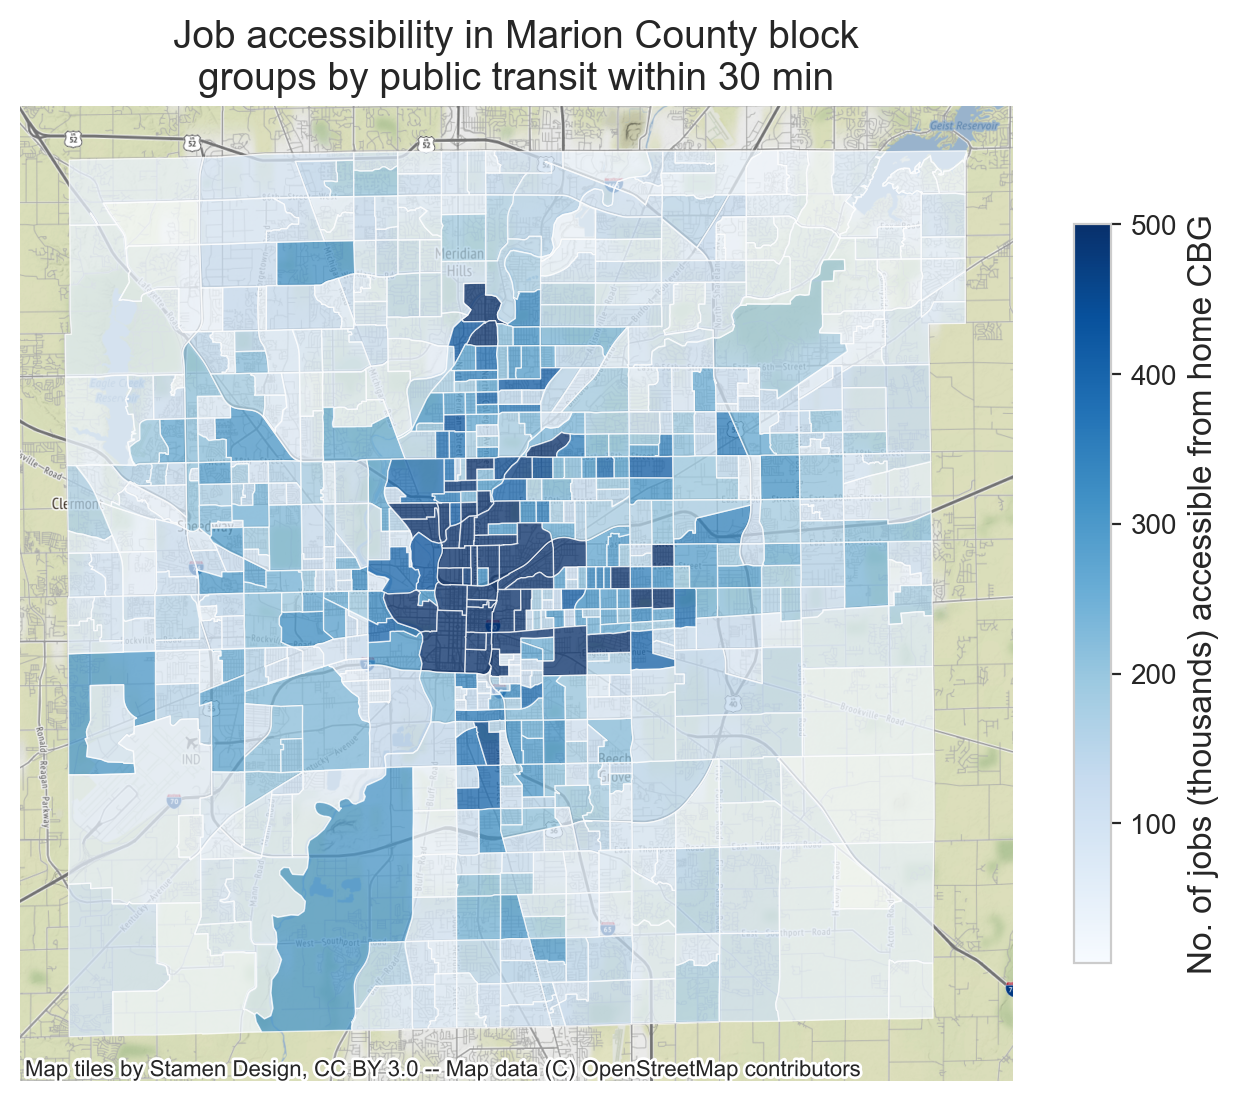

In [ ]:
df = aaa.query('scale=="BG" & mode=="Transit" & tt_thresh==30 & category=="Overall" & is_rac')
df = df[df['geoid'].str.startswith(bound.query('name=="Marion"')['geoid'].iloc[0])]
df = bound.merge(df, on='geoid').to_crs(CRS_M).assign(num_jobs=lambda df: df['num_jobs'] / 1e3)
ax = U.plot(size=(8, 8), dpi=200, axoff=1, title='Job accessibility in Marion County block\ngroups by public transit within 30 min')
df.plot(ax=ax, column='num_jobs', alpha=0.75, edgecolor='w', lw=0.5, cmap='Blues', vmax=500, legend=True,
        legend_kwds=dict(shrink=0.6, label='No. of jobs (thousands) accessible from home CBG'))
ctx.add_basemap(ax=ax, crs=CRS_M);

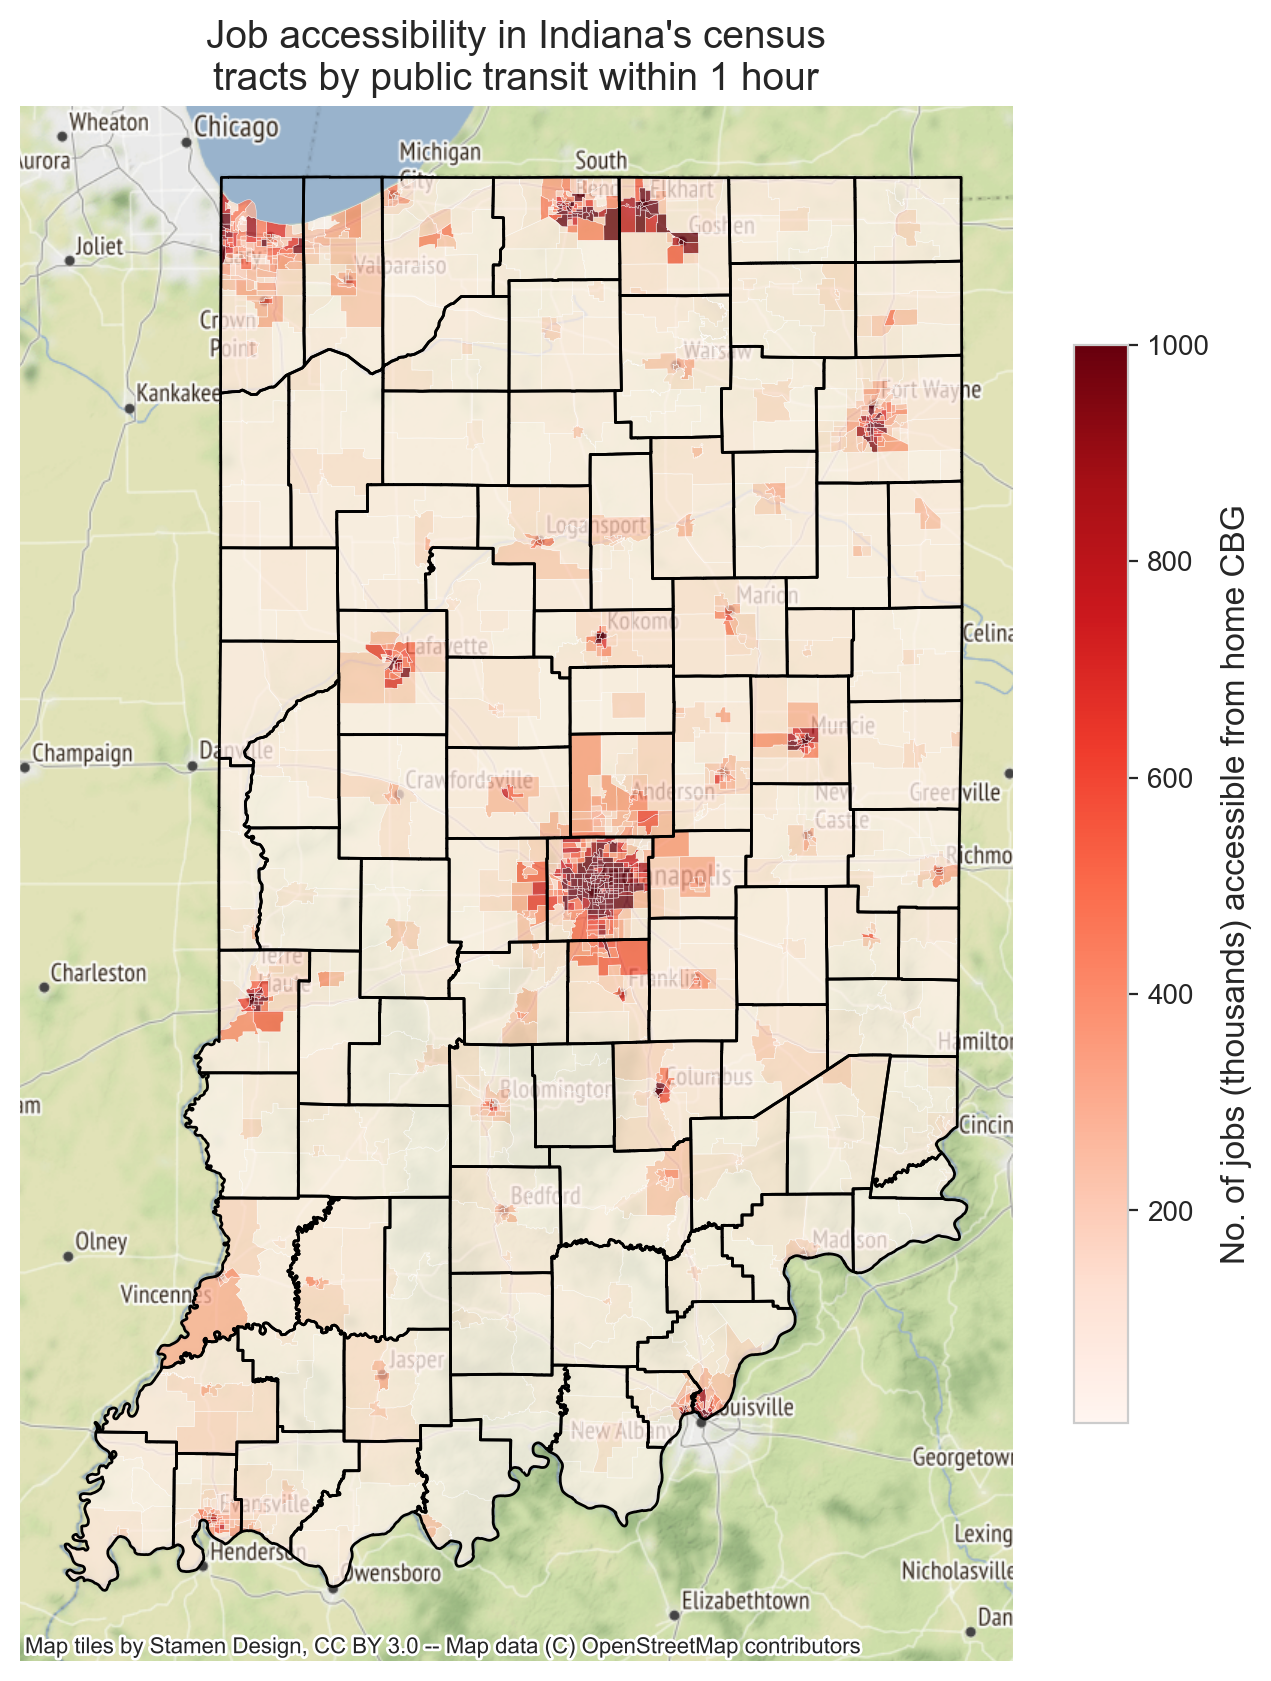

In [ ]:
df = aaa.query('scale=="Tract" & mode=="Transit" & tt_thresh==60 & is_rac & category=="Job earnings" & subcategory=="Low (<$1,250/mo)"')
df = bound.merge(df, on='geoid').to_crs(CRS_M).assign(num_jobs=lambda df: df['num_jobs']/1e3)
ax = U.plot(size=(8, 14), dpi=200, axoff=1, title='Job accessibility in Indiana\'s census\ntracts by public transit within 1 hour')
df.plot(ax=ax, column='num_jobs', alpha=0.75, edgecolor='w', lw=0.2, cmap='Reds', vmax=1e3, legend=True,
        legend_kwds=dict(shrink=0.5, label='No. of jobs (thousands) accessible from home CBG'))
bound.query('scale=="County"').to_crs(CRS_M).plot(ax=ax, facecolor='none', edgecolor='k', lw=1)
ctx.add_basemap(ax=ax, crs=CRS_M);

In [ ]:
ej = (ejs.query('ej_or_ses=="EJ" & value_or_pctile=="Percentile"')
      .pivot('geoid', 'variable', 'value')
      .rename(columns=str.strip).rename(columns={'Diesel particulate matter': 'Diesel PM'})
      [['Particulate Matter 2.5', 'Ozone', 'Diesel PM', 'Air toxics cancer risk',
        'Air toxics respiratory HI', 'Traffic proximity']])
ej = bound[['geoid', 'scale', 'name', 'geometry']].merge(ej, on='geoid').disp(3)

5,350 rows x 10 cols; Memory: 1.2 MiB; CRS: EPSG:4326


/tmp/ipykernel_192682/1279161963.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ej = (ejs.query('ej_or_ses=="EJ" & value_or_pctile=="Percentile"')


,geoid,scale,name,geometry,Particulate Matter 2.5,Ozone,Diesel PM,Air toxics cancer risk,Air toxics respiratory HI,Traffic proximity
,<object>,<object>,<object>,<geometry>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,181379685003,BG,None,"POLYGON ((-85.20815 39.304011, -85.208134 39.3...",47.0,23.0,10.0,0.0,86.0,73.0
1,181379685002,BG,None,"POLYGON ((-85.236724 39.298839, -85.236543 39....",47.0,23.0,10.0,0.0,86.0,35.0
2,181379685001,BG,None,"POLYGON ((-85.218627 39.296581, -85.219221 39....",47.0,23.0,10.0,0.0,86.0,75.0
